# Anti-money laundering (AML) alert scoring

## Summary

This use case aims to develop a machine learning model that utilizes historical data, including customer and transactional information, to identify alerts that resulted in the generation of a Suspicious Activity Report (SAR). The model will assign a suspicious activity score to future alerts, improving the effectiveness and efficiency of an AML compliance program by prioritizing alerts based on their ranking order according to the score. 

The following outlines aspects of this use case.

* **Use case type**:  Anti-money laundering (false positive reduction)
* **Target audience**: Data Scientist, Financial Crime Compliance Team
* **Desired outcomes**: <ul><li>Identify customer data and transaction activity indicative of a high risk for potential money laundering.</li><li>Detect anomalous changes in behavior or emerging money laundering patterns at an early stage.</li><li>Reduce the false positive rate for cases selected for manual review.</li></ul>
* **Metrics/KPIs**: <ul><li>Annual alert volume</li><li>Cost per alert</li><li>False positive reduction rate</li></ul>
* **[Sample dataset](https://s3.amazonaws.com/datarobot-use-case-datasets/DR_Demo_AML_Alert_train.csv)**

A crucial aspect of an effective AML compliance program involves monitoring transactions to detect suspicious activity. This encompasses various types of transactions, such as deposits, withdrawals, fund transfers, purchases, merchant credits, and payments. Typically, monitoring begins with a rules-based system that scans customer transactions for signs of potential money laundering. When a transaction matches a predefined rule, an alert is generated, and the case is referred to the bank's internal investigation team for manual review. If the investigators determine that the behavior is indicative of money laundering, a SAR is filed with FinCEN.

However, the aforementioned standard transaction monitoring system has significant drawbacks. Most notably, the system's rules-based and inflexible nature leads to a high rate of false positives, with as many as 90% of cases being incorrectly flagged as suspicious. This prevalence of false positives hampers investigators' efficiency as they are required to manually filter out cases erroneously identified by the rules-based system.

Financial institutions' compliance teams may have hundreds or even thousands of investigators, and the current systems hinder their effectiveness and efficiency in conducting investigations. The cost of reviewing an alert ranges from `$30` to `$70`. For a bank that receives 100,000 alerts per year, this amounts to a substantial sum. By reducing false positives, potential savings of `$600,000` to `$4.2 million` per year can be achieved.

Key takeaways:

* **Strategy/challenge**:  Facilitate investigators in focusing their attention on cases with the highest risk of money laundering, while minimizing time spent on reviewing false-positive cases.

    For banks dealing with a high volume of daily transactions, improving the effectiveness and efficiency of investigations ultimately leads to fewer unnoticed instances of money laundering. This enables banks to strengthen their regulatory compliance and reduce the prevalence of financial crimes within their network.

* **Business driver**: Enhance the efficiency of AML transaction monitoring and reduce operational costs.

    By harnessing their capability to dynamically learn patterns in complex data, machine learning models greatly enhance the accuracy of predicting which cases will result in a SAR filing. Machine learning models for anti-money laundering can be integrated into the review process to score and rank new cases.

* **Model solution**: Assign a suspicious activity score to each AML alert, thereby improving the efficiency of an AML compliance program.

    Any case exceeding a predetermined risk threshold is forwarded to investigators for manual review. Cases falling below the threshold can be automatically discarded or subject to a less intensive review. Once machine learning models are deployed in production, they can be continuously retrained using new data to detect novel money laundering behaviors, incorporating insights from investigator feedback.
    
    In particular, the model will employ rules that trigger an alert whenever a customer requests a refund of any amount. Small refund requests can be utilized by money launderers to test the refund mechanism or establish a pattern of regular refund requests for their account.

## Work with data

The linked synthetic dataset illustrates a credit card company’s AML compliance program. Specifically the model is detecting the following money-laundering scenarios:

- Customer spends on the card but overpays their credit card bill and seeks a cash refund for the difference.
- Customer receives credits from a merchant without offsetting transactions and either spends the money or requests a cash refund from the bank.

The unit of analysis in this dataset is an individual alert, meaning a rule-based engine is in place to produce an alert to detect potentially suspicious activity consistent with the above scenarios. 

### Problem framing

The target variable for this use case is **whether or not the alert resulted in a SAR** after manual review by investigators, making this a binary classification problem. The unit of analysis is an individual alert&mdash;the model will be built on the alert level&mdash;and each alert will receive a score ranging from 0 to 1. The score indicates the probability of the alert being a SAR.

The goal of applying a model to this use case is to lower the false positive rate, which means resources are not spent reviewing cases that are eventually determined to not be suspicious after an investigation. 

In this use case, the False Positive Rate of the rules engine on the validation sample (1600 records) is:

Number of `SAR=0` divided by the total number of records = `1436/1600` = `90%`.  

### Data preparation
    
Consider the following when working with data:
    
* **Define the scope of analysis**: Collect alerts from a specific analytical window to start with; it’s recommended that you use 12–18 months of alerts for model building.
    
* **Define the target**: Depending on the investigation processes, the target definition could be flexible. In this walkthrough, alerts are classified as `Level1`, `Level2`, `Level3`, and `Level3-confirmed`. These labels indicate at which level of the investigation the alert was closed (i.e., confirmed as a SAR). To create a binary target, treat `Level3-confirmed` as SAR (denoted by 1) and the remaining levels as non-SAR alerts (denoted by 0). 

* **Consolidate information from multiple data sources**: Below is a sample entity-relationship diagram indicating the relationship between the data tables used for this use case.
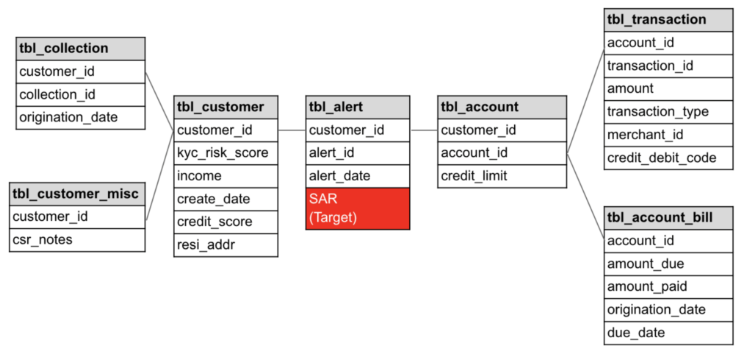

Some features are static information&mdash;`kyc_risk_score` and `state of residence` for example&mdash;these can be fetched directly from the reference tables.  

For transaction behavior and payment history, the information will be derived from a specific time window prior to the alert generation date. This case uses 90 days as the time window to obtain the dynamic customer behavior, such as `nbrPurchases90d`, `avgTxnSize90d`, or `totalSpend90d`.

### Features and sample data

The features in the sample dataset consist of KYC (Know-Your-Customer) information, demographic information, transactional behavior, and free-form text information from the customer service representatives’ notes. To apply this use case in your orgaization, your dataset should contain, minimally, the following features:

- Alert ID
- Binary classification target (`SAR/no-SAR`, `1/0`, `True/False`, etc.)
- Date/time of the alert
- "Know Your Customer" score used at time of account opening
- Account tenure, in months
- Total merchant credit in the last 90 days
- Number of refund requests by the customer in the last 90 days
- Total refund amount in the last 90 days

Other helpful features to include are:

- Annual income
- Credit bureau score
- Number of credit inquiries in the past year
- Number of logins to the bank website in the last 90 days
- Indicator that the customer owns a home
- Maximum revolving line of credit
- Number of purchases in the last 90 days
- Total spend in the last 90 days
- Number of payments in the last 90 days
- Number of cash-like payments (e.g., money orders) in last 90 days
- Total payment amount in last 90 days
- Number of distinct merchants purchased at in the last 90 days
- Customer Service Representative notes and codes based on conversations with customer (cumulative)


Below is an example of one row in the training data after it is merged and aggregated (it is broken into multiple lines for a easier visualization).
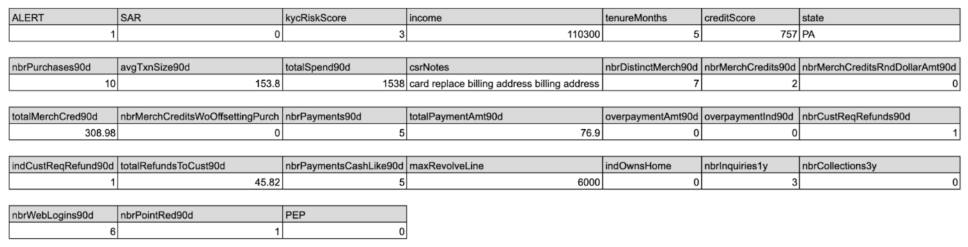


## Configure the Python client

The DataRobot API offers a programmatic alternative to the web interface for creating and managing DataRobot projects. It can be accessed through REST or DataRobot's Python and R clients, supporting Windows, UNIX, and OS X environments. To authenticate with DataRobot's API, you will need an endpoint and token, as detailed in the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/api/api-quickstart/index.html#configure-your-environment">documentation</a>. Once you have configured your API credentials, endpoints, and environment, you can leverage the DataRobot API to perform the following actions:

<ol start="1">
<li><b>Upload</b> a dataset.</li>
<li><b>Train</b> a model to learn from the dataset using the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/build-models/build-basic/feature-lists.html#automatically-created-feature-lists">Informative Features</a> feature list.</li>
<li><b>Test</b> prediction outcomes on the model using new data.</li>
<li><b>Deploy</b> the model.</li>
<li><b>Predict</b> outcomes using the deployed model and new data.</li>
</ol>

### Import libraries

In [1]:
# NOT required for Notebooks in DataRobot Workbench
# *************************************************
! pip install datarobot --quiet
# Upgrade DR to datarobot-3.2.0b0
# ! pip uninstall datarobot --yes
# ! pip install datarobot --pre

! pip install pandas --quiet
! pip install matplotlib --quiet

import getpass

import datarobot as dr

endpoint = "https://app.eu.datarobot.com/api/v2"
token = getpass.getpass()
dr.Client(endpoint=endpoint, token=token)
# *************************************************

········


In [2]:
import datetime as datetime
import os

import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd

params = {"axes.titlesize": "8", "xtick.labelsize": "5", "ytick.labelsize": "6"}
plt.rcParams.update(params)

## Analyze, clean, and curate data

Preparing data is an iterative process. Even if you have already cleaned and prepped your training data before uploading it, you can further enhance its quality by performing Exploratory Data Analysis (EDA).

In [3]:
# Load the training dataset
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot-use-case-datasets/DR_Demo_AML_Alert_train.csv",
    encoding="ISO-8859-1",
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ALERT                             10000 non-null  int64  
 1   SAR                               10000 non-null  int64  
 2   kycRiskScore                      10000 non-null  int64  
 3   income                            9800 non-null   float64
 4   tenureMonths                      10000 non-null  int64  
 5   creditScore                       10000 non-null  int64  
 6   state                             10000 non-null  object 
 7   nbrPurchases90d                   10000 non-null  int64  
 8   avgTxnSize90d                     10000 non-null  float64
 9   totalSpend90d                     10000 non-null  float64
 10  csrNotes                          10000 non-null  object 
 11  nbrDistinctMerch90d               10000 non-null  int64  
 12  nbrMe

The sample data contains the following features:
<ol start="0">
<li><b>ALERT</b>: Alert Indicator</li>
<li><b>SAR</b>: Target variable, SAR Indicator</li>
<li><b>kycRiskScore</b>: Account relationship (Know Your Customer) score used at time of account opening</li>
<li><b>income</b>: Annual income</li>
<li><b>tenureMonths</b>: Account tenure in months</li>
<li><b>creditScore</b>: Credit bureau score</li>
<li><b>state</b>: Account billing address state</li>
<li><b>nbrPurchases90d</b>: Number of purchases in last 90 days</li>
<li><b>avgTxnSize90d</b>: Average transaction size in last 90 days</li>
<li><b>totalSpend90d</b>: Total spend in last 90 days</li>
<li><b>csrNotes</b>: Customer Service Representative notes and codes based on conversations with customer</li>
<li><b>nbrDistinctMerch90d</b>: Number of distinct merchants purchased at in last 90 days</li>
<li><b>nbrMerchCredits90d</b>: Number of credits from merchants in last 90 days</li>
<li><b>nbrMerchCreditsRndDollarAmt90d</b>: Number of credits from merchants in round dollar amounts in last 90 days</li>
<li><b>totalMerchCred90d</b>: Total merchant credit amount in last 90 days</li>
<li><b>nbrMerchCreditsWoOffsettingPurch</b>: Number of merchant credits without an offsetting purchase in last 90 days</li>
<li><b>nbrPayments90d</b>: Number of payments in last 90 days</li>
<li><b>totalPaymentAmt90d</b>: Total payment amount in last 90 days</li>
<li><b>overpaymentAmt90d</b>: Total amount overpaid in last 90 days</li>
<li><b>overpaymentInd90d</b>: Indicator that account was overpaid in last 90 days</li>
<li><b>nbrCustReqRefunds90d</b>: Number refund requests by the customer in last 90 days</li>
<li><b>indCustReqRefund90d</b>: Indicator that customer requested a refund in last 90 days</li>
<li><b>totalRefundsToCust90d</b>: Total refund amount in last 90 days</li>
<li><b>nbrPaymentsCashLike90d</b>: Number of cash-like payments (e.g., money orders) in last 90 days</li>
<li><b>maxRevolveLine</b>: Maximum revolving line of credit</li>
<li><b>indOwnsHome</b>: Indicator that the customer owns a home</li>
<li><b>nbrInquiries1y</b>: Number of credit inquiries in the past year</li>
<li><b>nbrCollections3y</b>: Number of collections in the past year</li>
<li><b>nbrWebLogins90d</b>: Number of logins to the bank website in the last 90 days</li>
<li><b>nbrPointRed90d</b>: Number of loyalty point redemptions in the last 90 days</li>
    <li><b>PEP</b>: Politically Exposed Person indicator</li>
    </ol>


In [4]:
# Upload a dataset
ct = datetime.datetime.now()
file_name = f"AML_Alert_train_{int(ct.timestamp())}.csv"
dataset = dr.Dataset.create_from_in_memory_data(data_frame=df, fname=file_name)
dataset

Dataset(name='AML_Alert_train_1687350171.csv', id='6492eb9c1e1e2e52c305e3ca')

While a dataset is being registered in Workbench, DataRobot also performs EDA1 analysis and profiling for every feature to detect feature types, automatically transform date-type features, and assess feature quality. Once registration is complete, you can view the exploratory data insights uncovered while computing EDA1, as detailed in the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/workbench/wb-dataprep/wb-data-tab.html">documentation</a>.

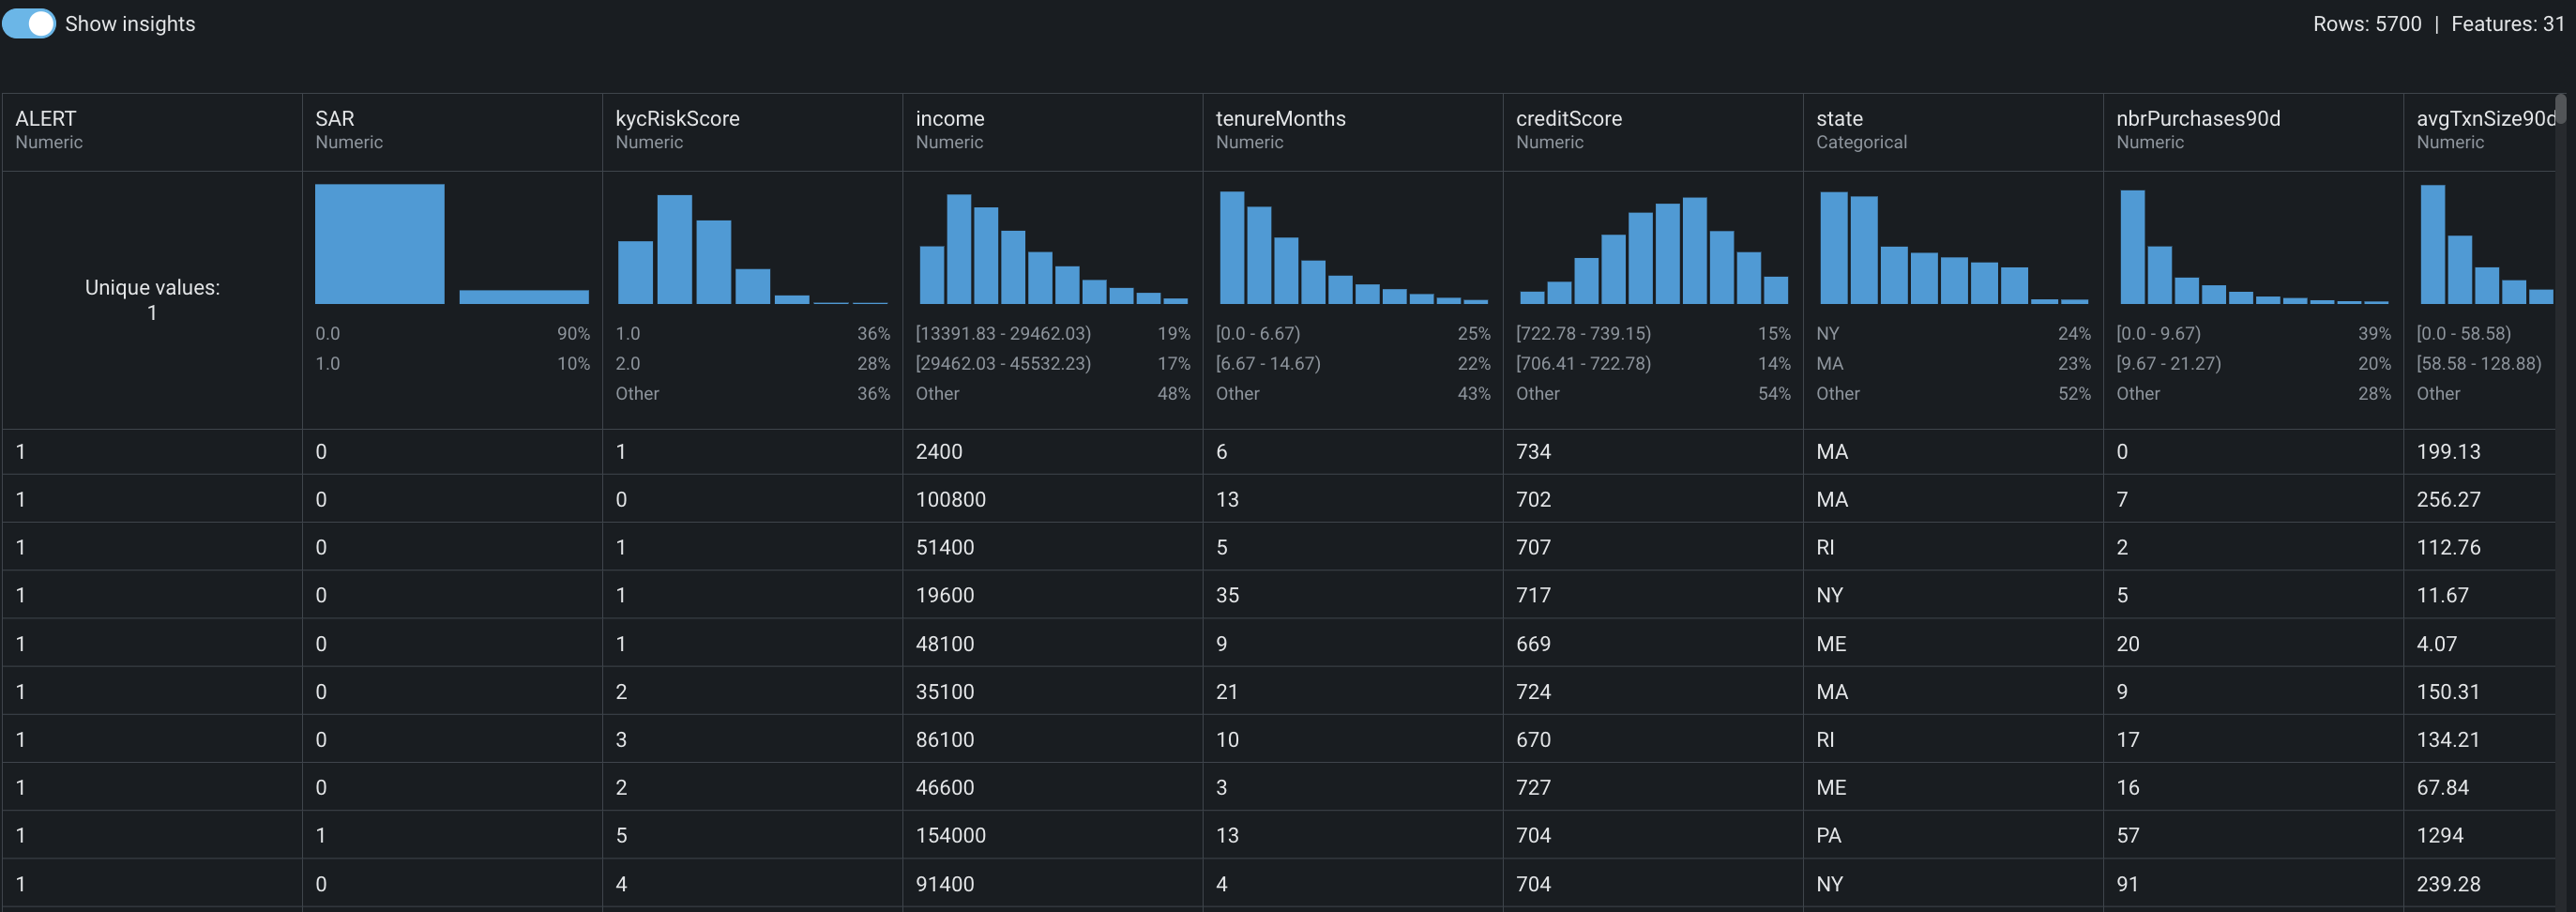

Based on the exploratory data insights above, you can draw the following quick observations:

1. The entire population of interest comprises only alerts, which aligns with the problem's focus.
2. The false positive alerts (`SAR=0`) account for approximately 90%, which is typical for AML problems.
3. Some features, such as `PEP`, do not offer any useful information as they consist entirely of zeroes or have a single value.
4. Certain features, like `nbrPaymentsCashLike90d`, exhibit signs of zero inflation.
5. There is potential to convert certain numerical features, such as `indOwnsHome`, into categorical features.

Additionally, DataRobot automatically detects and addresses common data quality issues with minimal or no user intervention. For instance, a binary column is automatically added within a blueprint to flag rows with excess zeros. This allows the model to capture potential patterns related to abnormal values. No further user action is required.

## Create and manage experiments
Experiments are the individual "projects" within a Use Case. They allow you to vary data, targets, and modeling settings to find the optimal models to solve your business problem. Within each experiment, you have access to its Leaderboard and model insights, as well as experiment summary information.

In [5]:
# Create a new project based on a dataset
ct = datetime.datetime.now()
project_name = f"Anti Money Laundering Alert Scoring_{int(ct.timestamp())}"
project = dataset.create_project(project_name=project_name)
print(
    f"""Project Details
Project URL: {project.get_uri()}
Project ID: {project.id}
Project Name: {project.project_name}
    """
)

Project Details
Project URL: https://app.eu.datarobot.com/projects/6492ebd2b83ed3cc6ec5bb2e/models
Project ID: 6492ebd2b83ed3cc6ec5bb2e
Project Name: Anti Money Laundering Alert Scoring_1687350226
    


### Start modeling

In [6]:
# Select modeling parameters and start the modeling process
project.analyze_and_model(target="SAR", mode=dr.AUTOPILOT_MODE.QUICK, worker_count="-1")

project.wait_for_autopilot(check_interval=20.0, timeout=86400, verbosity=0)

## Evaluate experiments
As you proceed with modeling, Workbench generates a model Leaderboard, a ranked list of models that facilitates quick evaluation. The models on the Leaderboard are ranked based on the selected optimization metrics, such as LogLoss in this case.

Autopilot, DataRobot's "survival of the fittest" modeling mode, automatically selects the most suitable predictive models for the specified target feature and trains them with increasing sample sizes. Autopilot not only identifies the best-performing models but also recommends a model that excels at predicting the target feature `SAR`. The model selection process considers a balance of accuracy, metric performance, and model simplicity. For a detailed understanding, please refer to the Model recommendation process <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html">Model recommendation process</a> description.

Within the Leaderboard, you can click on a specific model to access visualizations for further exploration, as outlined in the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/workbench/wb-experiment/wb-experiment-evaluate.html">documentation</a>.


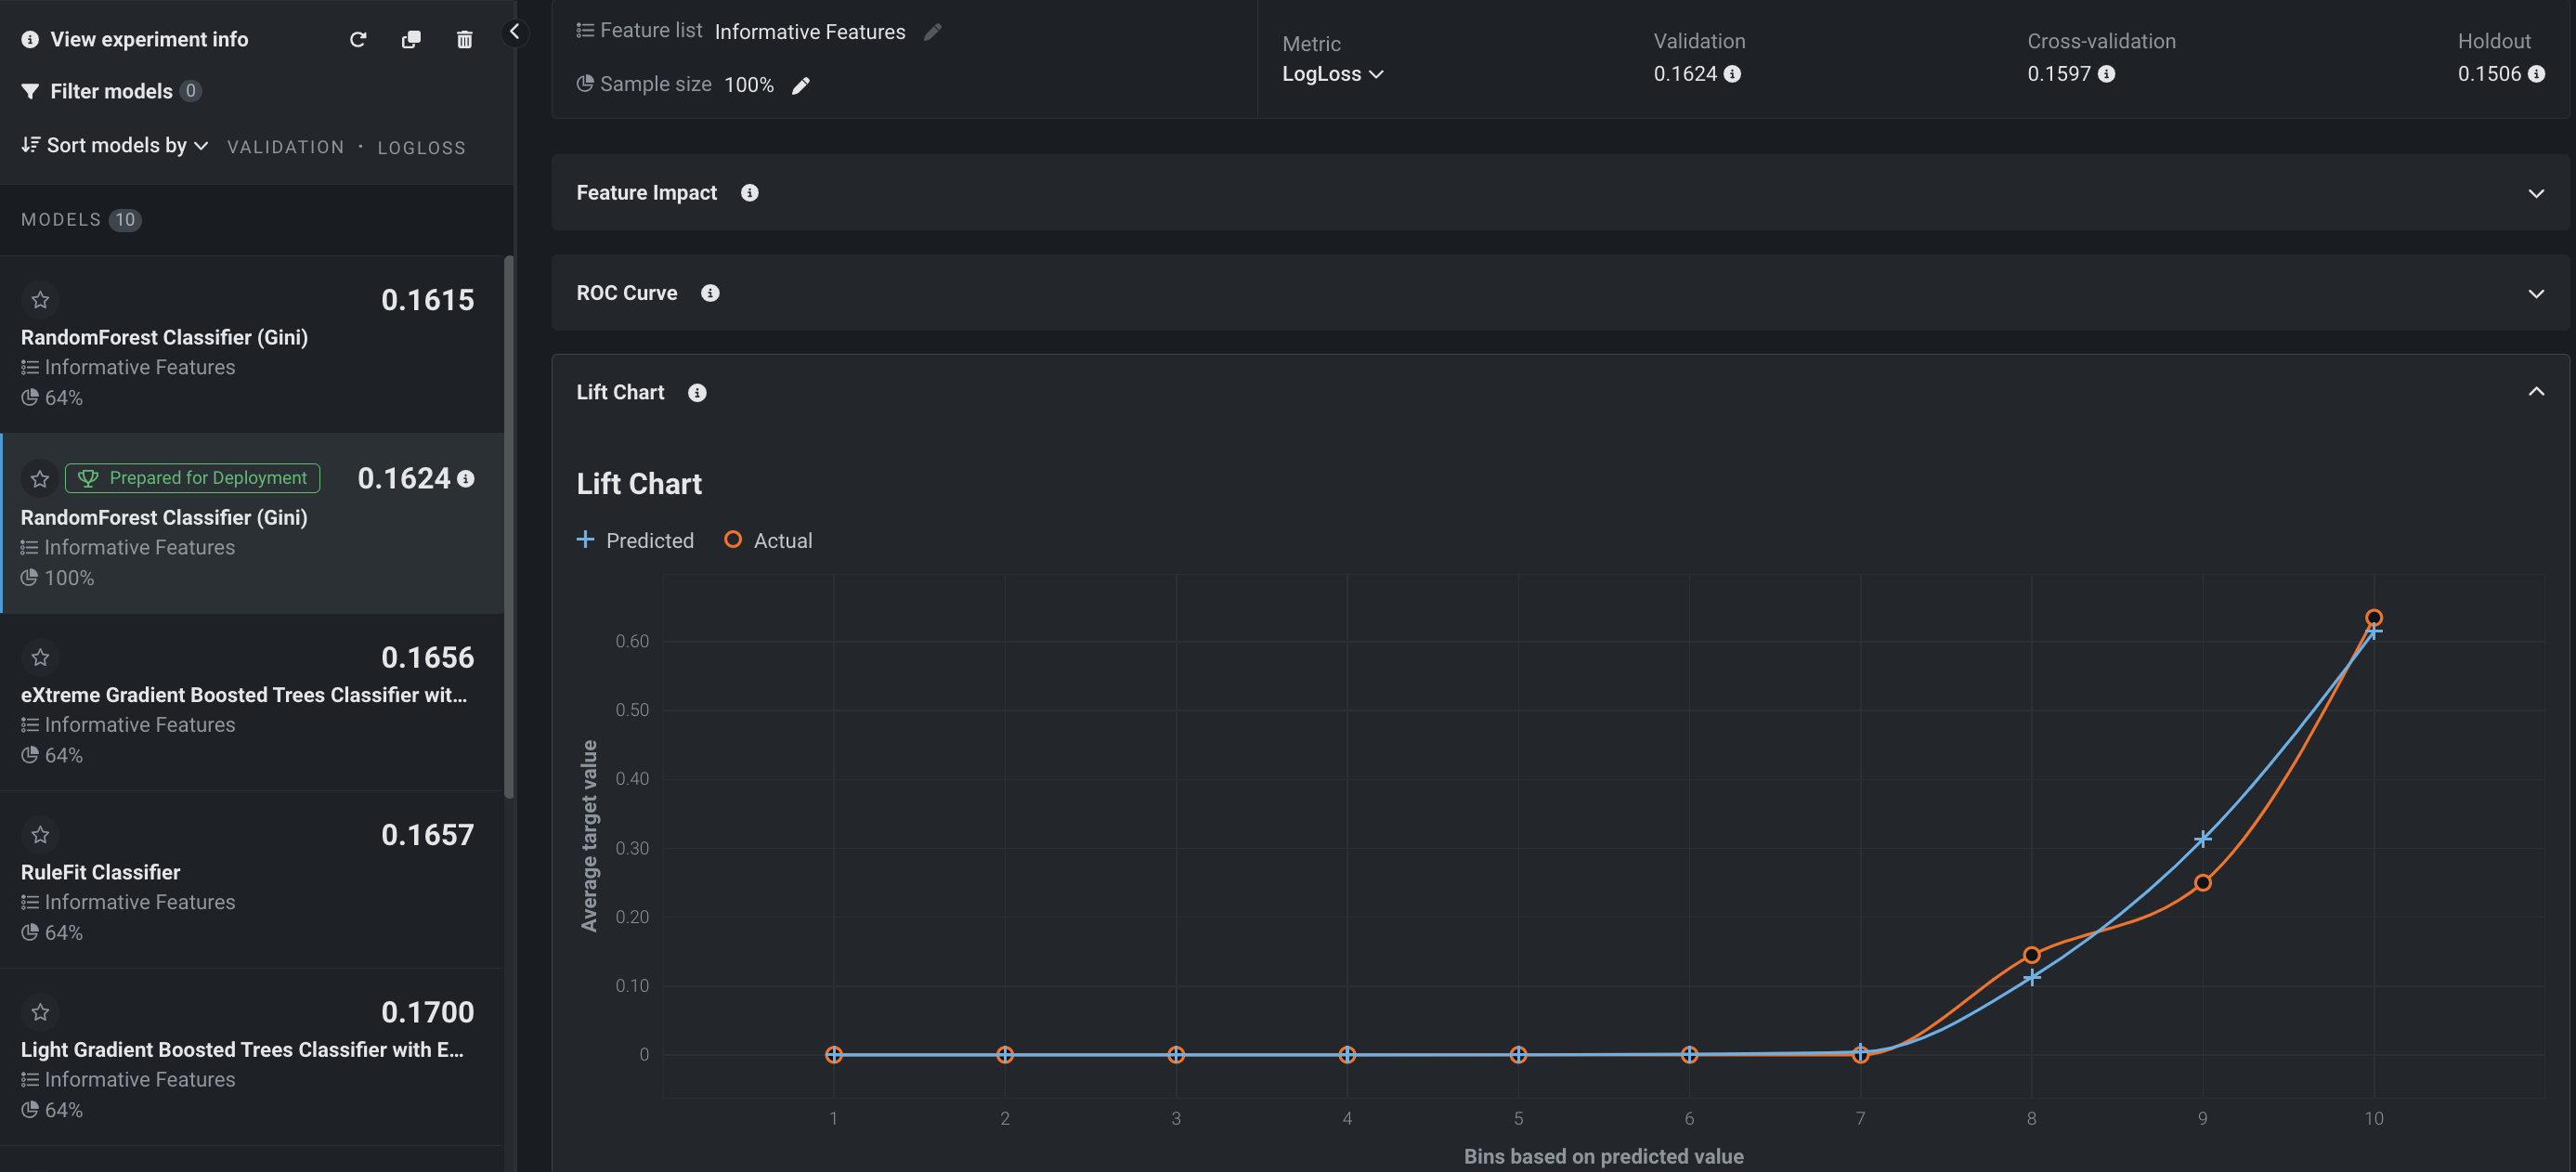

#### Lift Chart

The <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html"><b>Lift Chart</b></a> above shows how effective the model is at separating the SAR and non-SAR alerts. After an alert in the out-of-sample partition gets scored by the trained model, it will be assigned with a risk score that measures the likelihood of the alert being a SAR risk, or becoming a SAR. 

In the **Lift Chart**, alerts are sorted based on the SAR risk, broken down into 10 deciles, and displayed from lowest to the highest. For each decile, DataRobot computes the average predicted SAR risk (blue plus) as well as the average actual SAR event (orange circle) and depicts the two lines together. For the recommended model built for this false positive reduction use case, the SAR rate of the top decile is about 65%, which is a significant lift from the ~10% SAR rate in the training data. The top three deciles capture almost all SARs, which means that the 70% of alerts with very low predicted SAR risk rarely result in a SAR.

#### ROC Curve

Once you have confidence that the model is performing well, select an explicit threshold to make a binary decision based on the continuous SAR risk predicted by DataRobot. To pick up the optimal threshold, there are three important criteria:

1. The false negative rate has to be as small as possible. False negatives are the alerts that DataRobot determines are not SARs which then turn out to be true SARs. Missing a true SAR is very dangerous and would potentially result in an MRA (matter requiring attention) or regulatory fine. This example takes a conservative approach to have a `0` false negative rate, meaning all true SARs are captured. To achieve this, the threshold has to be low enough to capture all the SARs.

2. Keep the alert volume as low as possible to reduce enough false positives. In this context, all alerts generated in the past that are not SARs are the de-facto false positives; the machine learning model is likely to assign a lower score to those non-SAR alerts. Therefore, pick a high enough threshold to reduce as many false positive alerts as possible.

3. Ensure the selected threshold is not only working on the seen data, but also on the unseen data. This is required so that when the model is deployed to the transaction monitoring system for on-going scoring, it can still reduce false positives without missing any SARs.

From experimenting with different choices of thresholds using the cross-validation data (the data used for model training and validation), it seems that `0.03` is the optimal threshold since it satisfies the first two criteria. On one hand, the false negative rate is 0; on the other hand, the alert volume is reduced from 8000 to 2098 (False Positive + True Positive), meaning the number of investigations are reduced by 73% (5902/8000) without missing any SARs.

For the third criterion&mdash;setting the threshold to work on unseen alerts&mdash;you can quickly validate it in DataRobot. By changing the **Data Selection** dropdown to Holdout, and applying the same threshold (`0.03`), the false negative rate remains 0 and the reduction in investigations is still 73% (1464/2000). This proves that the model generalizes well and will perform as expected on unseen data.

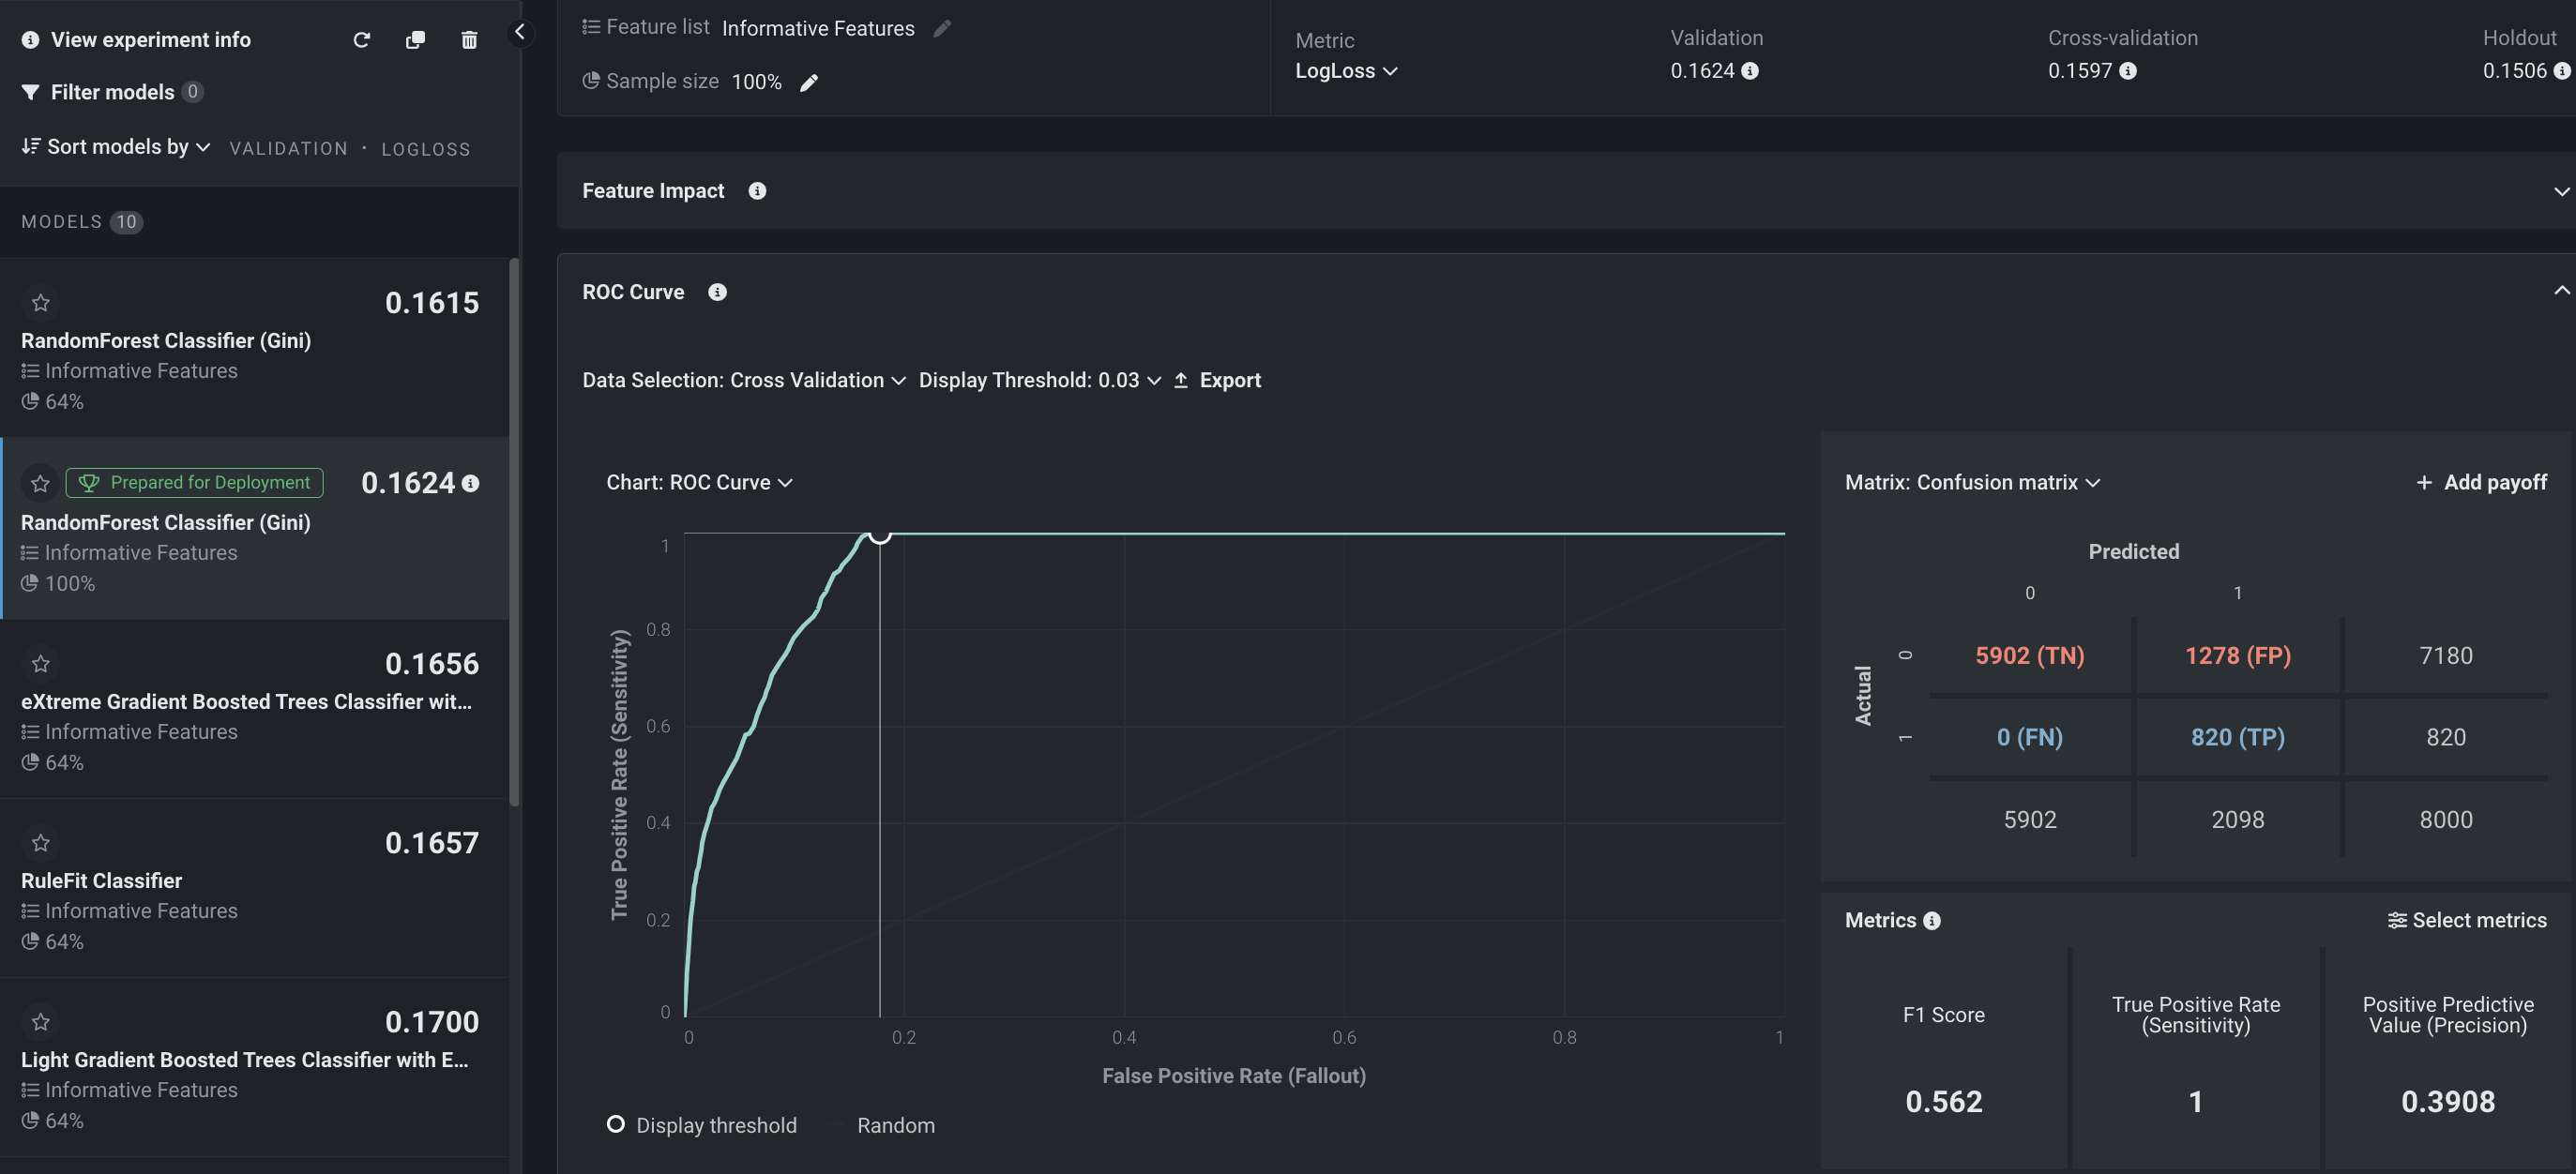

## Model insights

DataRobot offers a comprehensive suite of powerful tools and features designed to facilitate the interpretation, explanation, and validation of the factors influencing a model's predictions. One such tool is <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html"><b>Feature Impact</b></a>, which provides a high-level visualization that identifies the features that have the strongest influence on the model's decisions. A large impact indicates that removing this feature would significantly deteriorate the model's performance. On the other hand, features with lower impact may have relatively less importance individually but can still contribute to the overall predictive power of the model.



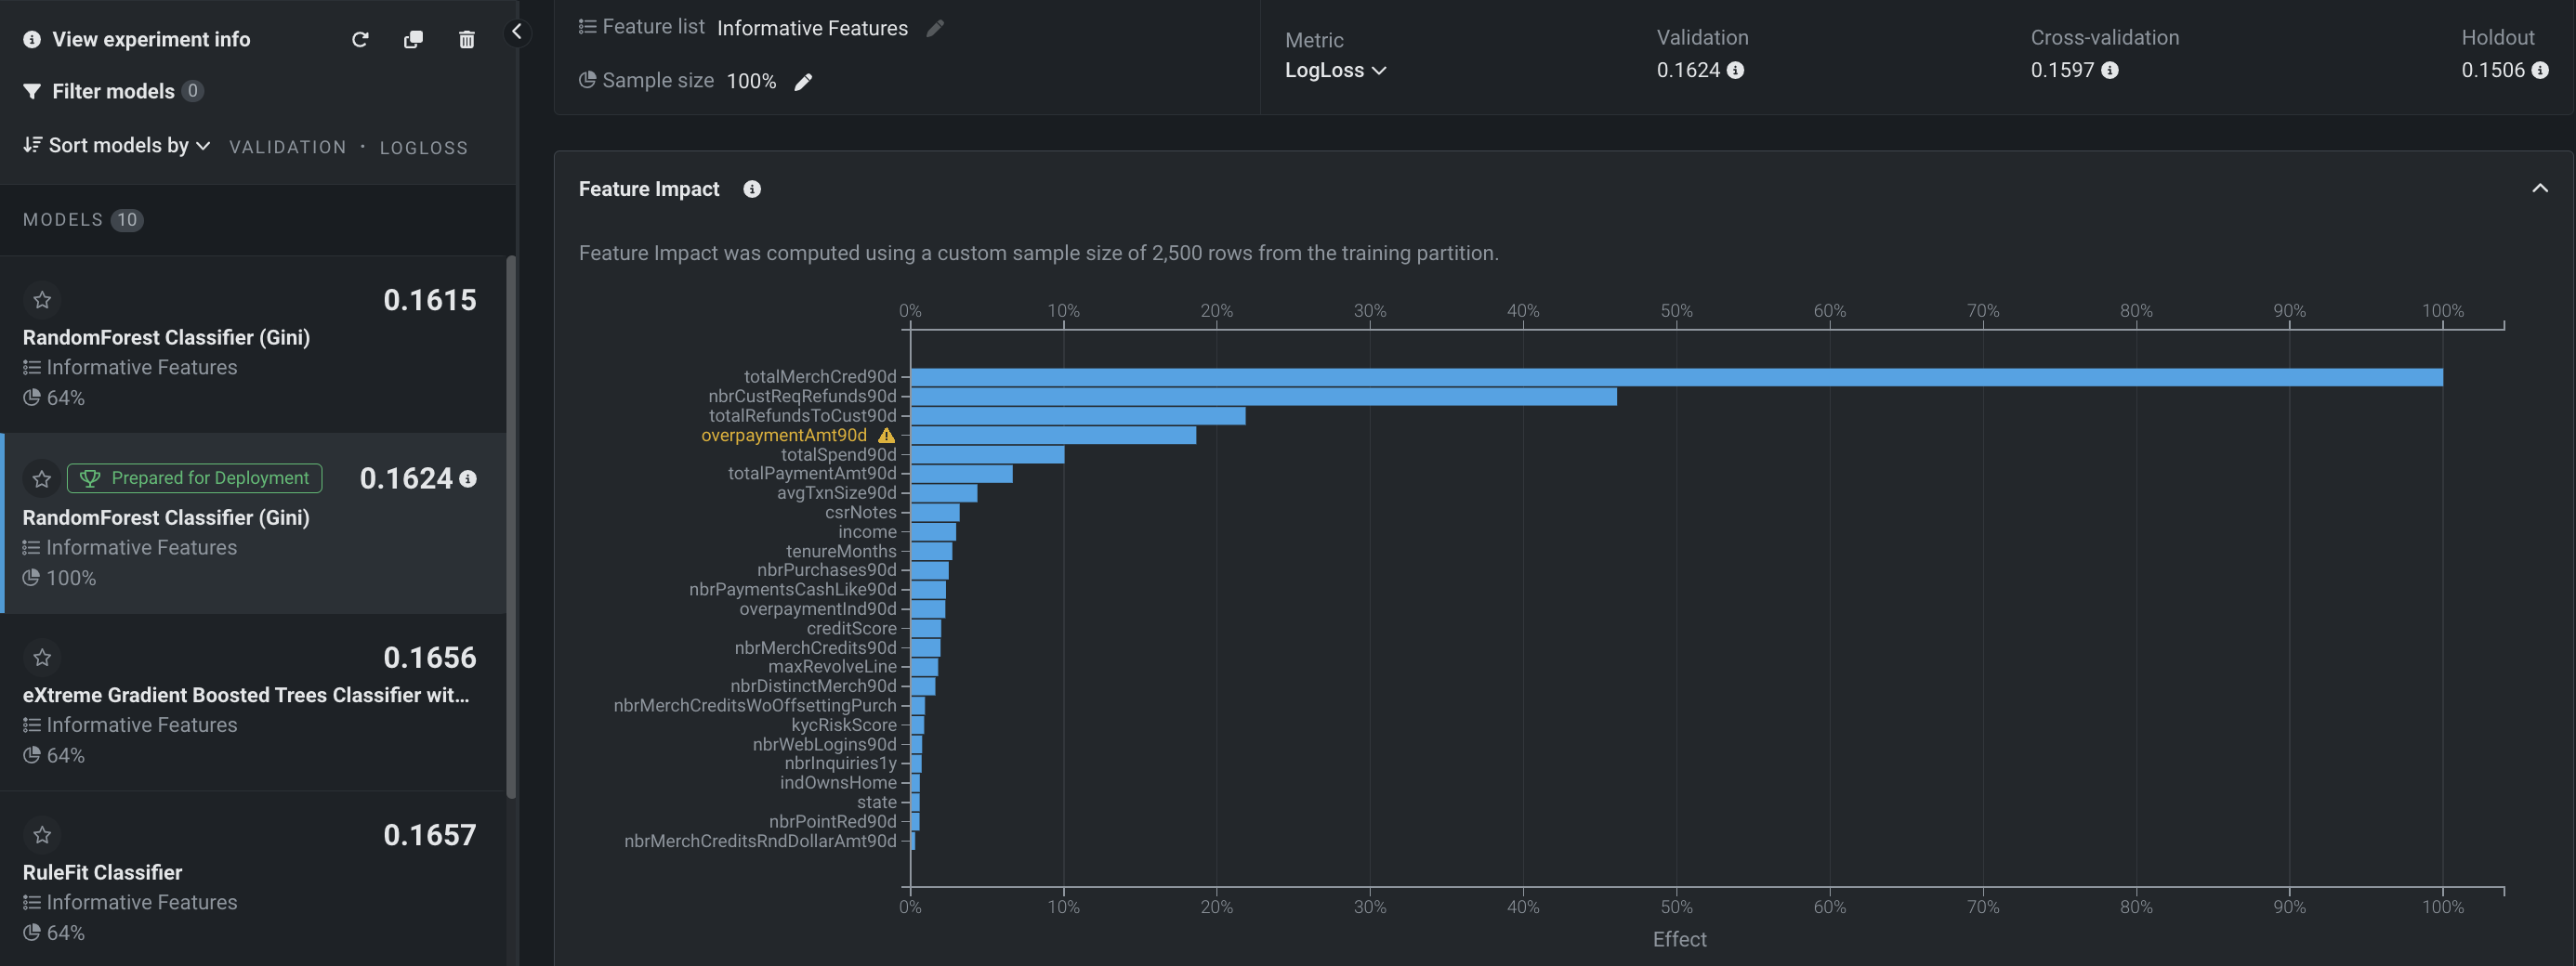

## Predict and deploy

Once you identify the model that best learns patterns in your data to predict SARs, DataRobot makes it easy to deploy the model into your alert investigation process. This is a critical step for implementing the use case, as it ensures that predictions are used in the real world to reduce false positives and improve efficiency in the investigation process. The following sections describe activities related to preparing and then deploying a model.

The following applications of the alert-prioritization score from the false positive reduction model both automate and augment the existing rule-based transaction monitoring system. 

* If the FCC (Financial Crime Compliance) team is comfortable with removing the low-risk alerts (very low prioritization score) from the scope of investigation, then the binary threshold selected during the model building stage will be used as the cutoff to remove those no-risk alerts. The investigation team will only investigate alerts above the cutoff, which will still capture all the SARs based on what was learned from the historical data.

* Often regulatory agencies will consider auto-closure or auto-removal as an aggressive treatment to production alerts. If auto-closing is not the ideal way to use the model output, the alert prioritization score can still be used to triage alerts into different investigation processes, hence improving the operational efficiency.

See the deep dive at the end of this use case for information on [decision process considerations](#deep-dive-decision-process-considerations).

You can use the following code to return the **Recommended for Deployment** model to use for model predictions.


In [7]:
model = dr.ModelRecommendation.get(project.id).get_model()
model

Model('RandomForest Classifier (Gini)')

### Compute predictions before deployment

By uploading an external dataset, you can ensure consistent performance in production prior to deployment. This new data will need to have the same transformations applied to the training data.

You can use the UI and follow the five steps of the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/analyze-models/predictions/predict.html#workflow-for-testing-predictions">workflow for testing predictions</a>. When predictions are complete, you can save prediction results to a CSV file.

With the following code, you can obtain more detailed results including predictions, probability of class_1 (`positive_probability`), probability of class_0 (autogenerated), actual values of the target (`SAR`), and all features. Furthermore, you can compute Prediction Explanations on this external dataset (which was not part of training data).

In [10]:
# Load an alert dataset for predictions
df_score = pd.read_csv(
    "https://s3.amazonaws.com/datarobot-use-case-datasets/DR_Demo_AML_Alert_pred.csv",
    encoding="ISO-8859-1",
)

# Get the recommended model
model_rec = dr.ModelRecommendation.get(project.id).get_model()
model_rec.set_prediction_threshold(0.03)

# Upload a scoring data set to DataRobot
prediction_dataset = project.upload_dataset(df_score.drop("SAR", axis=1))
predict_job = model_rec.request_predictions(prediction_dataset.id)

# Make predictions
predictions = predict_job.get_result_when_complete()

# Display prediction results
results = pd.concat(
    [predictions.drop("row_id", axis=1), df_score.drop("ALERT", axis=1)], axis=1
)
results.head()

,prediction,positive_probability,prediction_threshold,class_0.0,class_1.0,SAR,kycRiskScore,income,tenureMonths,creditScore,...,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,0.0,0.000000,0.03,1.000000,0.000000,0,2,54400.0,14,681,...,1,30.86,0,10000,0,4,0,8,2,0
1,0.0,0.000000,0.03,1.000000,0.000000,0,3,100100.0,37,702,...,1,65.72,0,13000,0,1,0,6,0,0
2,0.0,0.000000,0.03,1.000000,0.000000,0,3,59800.0,0,681,...,1,25.34,0,14000,1,4,0,8,1,0
3,1.0,0.120918,0.03,0.879082,0.120918,1,2,41100.0,5,718,...,1,2828.51,2,15000,1,3,0,6,1,0
4,1.0,0.407422,0.03,0.592578,0.407422,1,2,52100.0,3,704,...,1,2778.84,4,11000,1,3,0,3,2,0


Look at the results above. Since this is a binary classification problem:

* As the `positive_probability` approaches zero, the row is a stronger candidate for `class_0` with prediction value of 0 (the alert is not SAR).
* As `positive_probability` approaches one, the outcome is more likely to be of `class_1` with prediction value of 1 (the alert is SAR). 

From the KDE (Kernel Density Estimate) plot below, you can see that this sample of the data is weighted more strongly toward `class_0` (the alert is not SAR); the Probability Density for predictions is close to actuals.

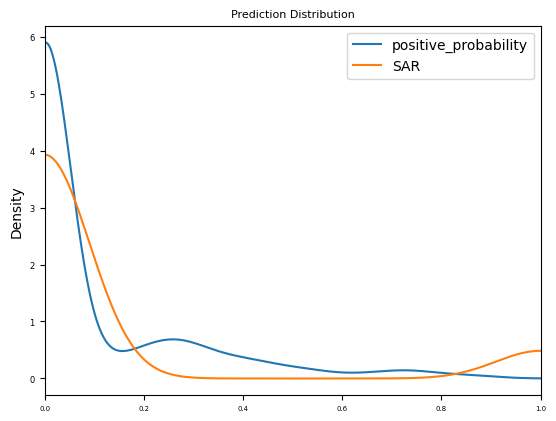

In [11]:
plt_kde = results[["positive_probability", "SAR"]].plot.kde(
    xlim=(0, 1), title="Prediction Distribution"
)

In [12]:
# Prepare Prediction Explanations
pe_init = dr.PredictionExplanationsInitialization.create(project.id, model_rec.id)
pe_init.wait_for_completion()

Computing Prediction Explanations is a resource-intensive task. You can set a maximum number of explanations per row and also configure prediction value thresholds to speed up the process.

Considering the prediction distribution above, set the `threshold_low` to `0.2` and `threshold_high` to `0.5`. This will provide Prediction Explanations only for those extreme predictions where `positive_probability` is lower than 0.2 or higher than 0.5.

In [13]:
# Compute Prediction Explanations with a custom config
number_of_explanations = 3
pe_comput = dr.PredictionExplanations.create(
    project.id,
    model_rec.id,
    prediction_dataset.id,
    max_explanations=number_of_explanations,
    threshold_low=0.2,
    threshold_high=0.5,
)
pe_result = pe_comput.get_result_when_complete()
explanations = pe_result.get_all_as_dataframe().drop("row_id", axis=1).dropna()
display(explanations.head())

,prediction,class_0_label,class_0_probability,class_1_label,class_1_probability,explanation_0_feature,explanation_0_feature_value,explanation_0_label,explanation_0_qualitative_strength,explanation_0_strength,explanation_1_feature,explanation_1_feature_value,explanation_1_label,explanation_1_qualitative_strength,explanation_1_strength,explanation_2_feature,explanation_2_feature_value,explanation_2_label,explanation_2_qualitative_strength,explanation_2_strength
0,0.0,0.0,1.000000,1.0,0.000000,totalSpend90d,216.25,1.0,--,-3.210206,nbrPaymentsCashLike90d,0,1.0,--,-2.971257,csrNotes,card replace statement customer call statement,1.0,--,-2.819563
1,0.0,0.0,1.000000,1.0,0.000000,avgTxnSize90d,14.92,1.0,--,-3.834376,totalSpend90d,775.84,1.0,--,-3.261914,totalMerchCred90d,80.47,1.0,--,-2.982999
2,0.0,0.0,1.000000,1.0,0.000000,totalSpend90d,488.88,1.0,--,-3.200760,nbrPaymentsCashLike90d,0,1.0,--,-3.031098,totalMerchCred90d,17.0,1.0,--,-2.990864
3,1.0,0.0,0.879082,1.0,0.120918,nbrCustReqRefunds90d,4,1.0,---,-1.514812,csrNotes,billing address plastic replace moneyorder,1.0,---,-0.708436,avgTxnSize90d,15.61,1.0,-,-0.141831
5,0.0,0.0,0.983790,1.0,0.016210,avgTxnSize90d,95.55,1.0,--,-0.402981,csrNotes,customer call statement moneyorder,1.0,++,0.390769,nbrPurchases90d,96,1.0,--,-0.329526


The following code lets you see how often various features are showing up as the top explanation for impacting the probability of SAR.

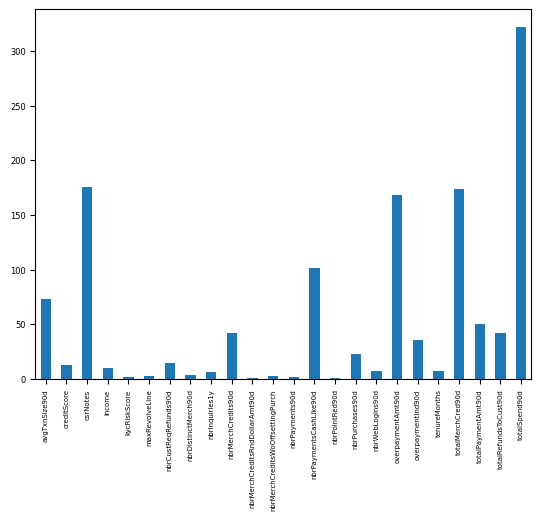

In [14]:
from functools import reduce

# Create a combined histogram of all the explanations
explanations_hist = reduce(
    lambda x, y: x.add(y, fill_value=0),
    (
        explanations["explanation_{}_feature".format(i)].value_counts()
        for i in range(number_of_explanations)
    ),
)

plt_expl = explanations_hist.plot.bar()

Having seen the model's **Feature Impact** insight earlier, the high occurrence of `totalSpend90d`, `overPaymentAmt90d`, and `totalMerchCred90d` as Prediction Explanations is not entirely surprising. These were some of the top-ranked features in the impact chart.

### Deploy a model and monitor performance

The DataRobot platform offers a wide variety of deployment methods, among which the most direct route is deploying a model from the Leaderboard. When you create a deployment from the Leaderboard, DataRobot automatically creates a model package for the deployed model. You can access the model package at any time in the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/mlops/deployment/registry/index.html#model-registry">Model Registry</a>. For more details, see the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/mlops/deployment/deploy-methods/deploy-model.html#deploy-from-the-leaderboard">documentation</a> for deploying from the Leaderboard. The programmatic alternative to create deployments can be implemented by the code below.

DataRobot will continuously <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/mlops/index.html">monitor the model</a> deployed on the dedicated prediction server. With DataRobot MLOps, the modeling team can monitor and manage the alert prioritization model by tracking the distribution drift of the input features as well as the performance deprecation over time.

In [15]:
pred_serv_id = dr.PredictionServer.list()[0].id
deployment = dr.Deployment.create_from_learning_model(
    model_id=model_rec.id,
    label="Anti Money Laundering Alert Scoring",
    description="Anti Money Laundering Alert Scoring",
    default_prediction_server_id=pred_serv_id,
)
deployment

Deployment(Anti Money Laundering Alert Scoring)

When you select a deployment from the Deployments Inventory, DataRobot opens to the <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html">Overview page</a> for that deployment, which provides a model and environment specific summary that describes the deployment, including the information you supplied when creating the deployment and any model replacement activity.

The <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/mlops/monitor/service-health.html">Service Health</a> tab tracks metrics about a deployment's ability to respond to prediction requests quickly and reliably. This helps identify bottlenecks and assess capacity, which is critical to proper provisioning.

The <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/mlops/monitor/data-drift.html">Data Drift</a> tab provides interactive and exportable visualizations that help identify the health of a deployed model over a specified time interval.


## Implementation risks
When operationalizing this use case, consider the following, which may impact outcomes and require model re-evaluation:

* Change in the transactional behavior of the money launderers.
* Novel information introduced to the transaction, and customer records that are not seen by the machine learning models.

## Deep dive: Imbalanced targets

In AML and Transaction Monitoring, the SAR rate is usually very low (1%–5%, depending on the detection scenarios); sometimes it could be even lower than 1% in extremely unproductive scenarios. In machine learning, such a problem is called _class imbalance_. The question becomes, how can you mitigate the risk of class imbalance and let the machine learn as much as possible from the limited known-suspicious activities?

DataRobot offers different techniques to handle class imbalance problems. Some techniques:

* Evaluate the model with <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/reference/model-detail/opt-metric.html#optimization-metrics"><b>different metrics</b></a>. For binary classification (the false positive reduction model here, for example), LogLoss is used as the default metric to rank models on the Leaderboard. Since the rule-based system is often unproductive, which leads to very low SAR rate, it’s reasonable to take a look at a different metric, such as the SAR rate in the top 5% of alerts in the prioritization list. The objective of the model is to assign a higher prioritization score with a high risk alert, so it’s ideal to have a higher rate of SAR in the top tier of the prioritization score. In the example shown in the image below, the SAR rate in the top 5% of prioritization score is more than 70% (original SAR rate is less than 10%), which indicates that the model is very effective in ranking the alert based on the SAR risk.

* DataRobot also provides flexibility for modelers when tuning hyperparameters which could also help with the class imbalance problem. In the example below, the Random Forest Classifier is tuned by enabling the balance_boostrap (random sample equal amount of SAR and non-SAR alerts in each decision trees in the forest); you can see the validation score of the new ‘Balanced Random Forest Classifier’ model is slightly better than the parent model.

* You can also use <a target="_blank" rel="noopener noreferrer" href="https://docs.datarobot.com/en/docs/modeling/build-models/adv-opt/smart-ds.html#smart-downsampling"><b>Smart Downsampling</b></a> (from the Advanced Options tab) to intentionally downsample the majority class (i.e., non-SAR alerts) in order to build faster models with similar accuracy.


## Deep Dive: Decision process

A review process typically consists of a deep-dive analysis by investigators. The data related to the case is made available for review so that the investigators can develop a 360-degree view of the customer, including their profile, demographic, and transaction history. Additional data from third-party data providers, and web crawling, can supplement this information to complete the picture.

For transactions that do not get auto-closed or auto-removed, the model can help the compliance team create a more effective and efficient review process by triaging their reviews. The predictions and their explanations also give investigators a more holistic view when assessing cases. 

### Risk-based alert triage

Based on the prioritization score, the investigation team could take different investigation strategies. For example: 

* No-risk or low-risk alerts can be reviewed on a quarterly basis, instead of monthly. The frequently alerted entities without any SAR risk can then be reviewed once every three months, which will significantly reduce the time of investigation.

* High-risk alerts with higher prioritization scores can have their investigation fast-tracked to the final stage in the alert escalation path. This will significantly reduce the effort spent on level 1 and level 2 investigation.

* Medium-risk alerts can use standard investigation process.

### Smart alert assignment

For an alert investigation team that is geographically dispersed, the alert prioritization score can be used to assign alerts to different teams in a more effective manner. High-risk alerts can be assigned to the team with the most experienced investigators while low risk alerts can be handled by a less experienced team. This mitigates the risk of missing suspicious activities due to lack of competency with alert investigations.

For both approaches, the definition of high/medium/low risk could be either a set of hard thresholds (for example, High: score>=0.5, Medium: 0.5>score>=0.3, Low: score<0.3), or based on the percentile of the alert scores on a monthly basis (for exxample, High: above 80th percentile, Medium: between 50th and 80th percentile, Low: below 50th percentile).


## Copyright / License

All datasets are Copyright YEAR DataRobot, Inc. All rights reserved.

All datasets are distributed under the [DataRobot Tool and Utility License](https://www.datarobot.com/wp-content/uploads/2021/07/DataRobot-Tool-and-Utility-Agreement.pdf).
